In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import os
os.chdir(r'C:\Users\VISHY\Desktop\Great Learning\Capstone\CAPSTONE\Data')

In [94]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [95]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type'],axis=1)

In [96]:
df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [97]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [98]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [99]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [100]:
num_cols=['asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment','PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES']

In [104]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','pri_inactive_accts','sec_inactive_accts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [105]:
df['number_of_0'] = (df == 0).astype(int).sum(axis=1)

In [106]:
(df == 0).astype(int).sum(axis=1)

0         18
1          8
2         19
3         12
4         17
          ..
233149     9
233150    13
233151    18
233152    18
233153    18
Length: 233154, dtype: int64

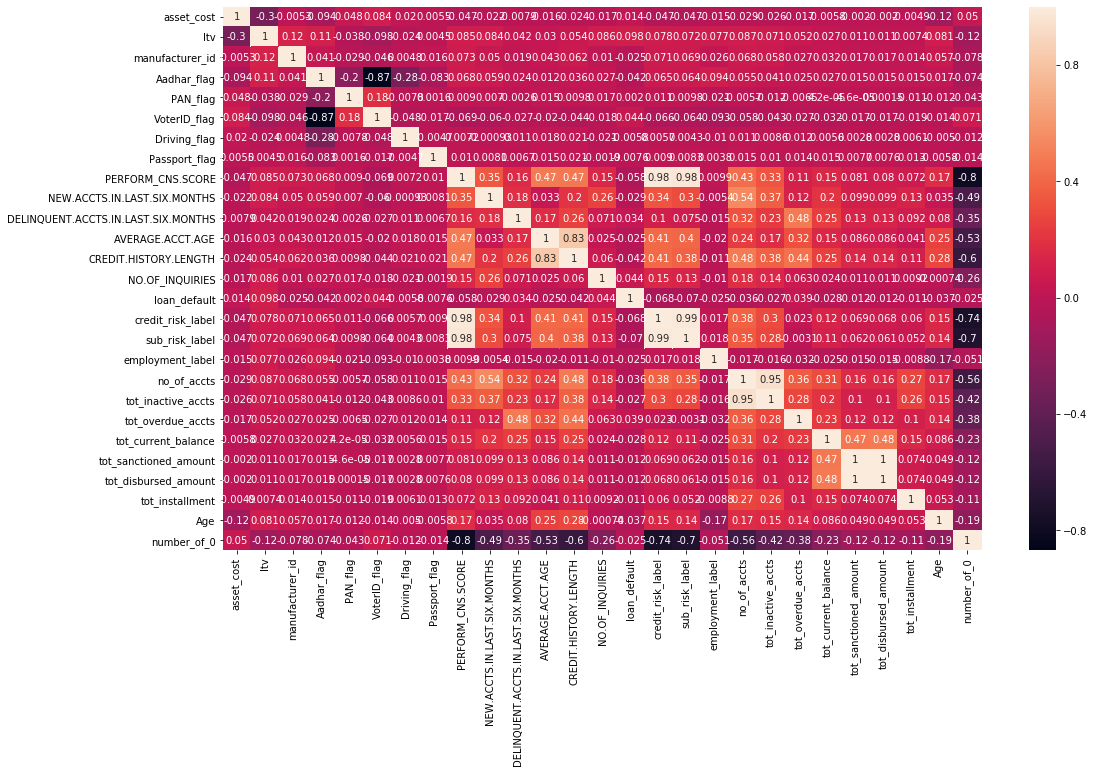

In [41]:
plt.figure(figsize=(17,10))
sns.heatmap(df.corr(),annot=True)

In [64]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_sanctioned_amount',
       'tot_disbursed_amount', 'tot_installment', 'Age'],
      dtype='object')

In [118]:
cols=['asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment']

In [67]:
col,val=[],[]
for i in cols:
    q1=df[i].quantile(0.25)
    q3=df[i].quantile(0.75)
    iqr=q3-q1
    print(i, q3+iqr)
    df.loc[df[i] > q3+iqr,i] = np.nan
df.loc[df['tot_current_balance'] < q1-iqr,'tot_current_balance'] = np.nan

asset_cost 92686.5
tot_current_balance 74672.0
tot_sanctioned_amount 131299.5
tot_disbursed_amount 128568.0
tot_installment 4166.0


In [68]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [69]:
imputer = IterativeImputer(missing_values=np.nan, random_state=0)

In [71]:
dff=imputer.fit_transform(df[cols])

In [72]:
dff=pd.DataFrame(dff, columns=cols)

In [73]:
df=df.drop(cols,axis=1)

In [74]:
df=pd.concat([df,dff],axis=1)
df

,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,...,employment_label,no_of_accts,tot_inactive_accts,tot_overdue_accts,Age,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,89.55,45,1,0,0,0,0,0,0,0,...,1,0,0,0,34,58400.000000,0.000000,0.000000,0.000000,0.0
1,73.23,45,1,0,0,0,0,598,0,1,...,0,1,0,1,33,65550.000000,27600.000000,50200.000000,50200.000000,1991.0
2,89.63,45,1,0,0,0,0,0,0,0,...,0,0,0,0,33,61360.000000,0.000000,0.000000,0.000000,0.0
3,88.48,45,1,0,0,0,0,305,0,0,...,0,3,3,0,25,66113.000000,0.000000,0.000000,0.000000,31.0
4,88.39,45,1,0,0,0,0,0,0,0,...,0,0,0,0,41,60300.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,60.72,48,0,0,1,0,0,735,0,0,...,1,4,1,0,30,67892.435602,16085.638629,29404.108911,30602.022591,4084.0
233150,74.95,51,0,0,1,0,0,825,0,0,...,0,1,1,0,30,69302.853227,0.000000,0.000000,0.000000,1565.0
233151,48.45,86,1,0,0,0,0,0,0,0,...,1,0,0,0,42,71212.000000,0.000000,0.000000,0.000000,0.0
233152,49.10,86,1,0,0,0,0,0,0,0,...,1,0,0,0,24,73286.000000,0.000000,0.000000,0.000000,0.0


In [11]:
df

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,sub_risk_label,employment_label,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,Age
0,58400,89.55,45,1,0,0,0,0,0,0,...,-1,1,0,0,0,0,0,0,0,34
1,65550,73.23,45,1,0,0,0,0,598,0,...,5,0,1,0,1,27600,50200,50200,1991,33
2,61360,89.63,45,1,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,33
3,66113,88.48,45,1,0,0,0,0,305,0,...,2,0,3,3,0,0,0,0,31,25
4,60300,88.39,45,1,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,105405,60.72,48,0,0,1,0,0,735,0,...,10,1,4,1,0,390443,416133,416133,4084,30
233150,100600,74.95,51,0,0,1,0,0,825,0,...,13,0,1,1,0,0,0,0,1565,30
233151,71212,48.45,86,1,0,0,0,0,0,0,...,-1,1,0,0,0,0,0,0,0,42
233152,73286,49.10,86,1,0,0,0,0,0,0,...,-1,1,0,0,0,0,0,0,0,24


In [12]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_sanctioned_amount',
       'tot_disbursed_amount', 'tot_installment', 'Age'],
      dtype='object')

In [110]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','no_of_accts', 'tot_inactive_accts',
       'tot_overdue_accts', 'tot_current_balance', 'tot_sanctioned_amount',
       'tot_disbursed_amount', 'tot_installment','Age']

In [35]:
df.shape

(233154, 27)

In [107]:
df['number_of_0'].value_counts()

18    53646
19    42796
9     22696
8     20297
10    18878
17    17375
11    13005
7     12163
12    10741
13     8667
6      4833
14     4030
16     1998
5      1306
15      476
4       229
3        18
Name: number_of_0, dtype: int64

In [68]:
df.shape

(233154, 27)

In [109]:
df = df[df['number_of_0']<=17]

In [111]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])


In [112]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [113]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [114]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [115]:
# for Test set
model_score = lr.score(X_test,y_test)
print(model_score)

0.6827668600965524


In [116]:
print("precision :",precision_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")

precision : 0.44440906775343864 

f1 score: 0.5175571952983055 

